In [21]:
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense
from keras.layers.convolutional import Conv3D
from keras.layers.pooling import MaxPooling3D, GlobalAveragePooling3D, AveragePooling3D
from keras import metrics
from keras import optimizers
from keras import backend as K
from keras.utils.training_utils import multi_gpu_model
from keras.utils.data_utils import Sequence
from keras.callbacks import ModelCheckpoint
from keras.initializers import he_uniform
import htmd.ui as ht
import htmd.molecule.voxeldescriptors as vd
import htmd.vmdviewer as vmdviewer
import csv
import pickle
import numpy as np
from tqdm import *
import bcolz as bc
import glob
import os
import random
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

In [22]:
%matplotlib inline

In [41]:
def get_model(summary=False):
    """ Return the Keras model of the network
    """
    model = Sequential()
    
    # 1st layer group
    model.add(Conv3D(filters=32,
                     kernel_size=(5, 5, 5),
                     strides = (1, 1, 1),
                     input_shape=(50, 50, 50, 16),
                     padding='valid',
                     activation='relu',
                     kernel_initializer=he_uniform(seed=9876),
                     bias_initializer='zeros'))
    
    model.add(MaxPooling3D(pool_size=(2, 2, 2),
                           padding='valid'))
    
    # 2nd layer group
    model.add(Conv3D(filters=64,
                     kernel_size=(3, 3, 3),
                     strides = (1, 1, 1),
                     activation='relu',
                     padding='valid'))
    
    model.add(MaxPooling3D(pool_size=(2, 2, 2),
                           padding='valid'))
    
    # 3rd layer group
    model.add(Conv3D(filters=128,
                     kernel_size=(3, 3, 3),
                     strides = (1, 1, 1),
                     activation='relu',
                     padding='valid'))
    
    model.add(MaxPooling3D(pool_size=(2, 2, 2),
                           padding='valid'))
    
    # 4th layer group
#     model.add(Conv3D(filters=128,
#                      kernel_size=(3, 3, 3),
#                      activation='relu',
#                      padding='valid'))
    
#     model.add(MaxPooling3D(pool_size=(2, 2, 2),
#                            #strides=(1, 1, 1),
#                            padding='valid'))
    
    #model.add(AveragePooling3D(pool_size=(2, 2, 2), 
    #                           padding='valid'))
                           
    model.add(Flatten())
#     model.add(Dense(512, activation='relu'))
#     model.add(Dropout(.5))
    model.add(Dense(256, activation='relu'))
#     model.add(Dropout(.5))
    model.add(Dense(1, activation='linear'))
    if summary:
        print(model.summary())
    return model

In [42]:
get_model(summary=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_16 (Conv3D)           (None, 46, 46, 46, 32)    64032     
_________________________________________________________________
max_pooling3d_16 (MaxPooling (None, 23, 23, 23, 32)    0         
_________________________________________________________________
conv3d_17 (Conv3D)           (None, 21, 21, 21, 64)    55360     
_________________________________________________________________
max_pooling3d_17 (MaxPooling (None, 10, 10, 10, 64)    0         
_________________________________________________________________
conv3d_18 (Conv3D)           (None, 8, 8, 8, 128)      221312    
_________________________________________________________________
max_pooling3d_18 (MaxPooling (None, 4, 4, 4, 128)      0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 8192)              0         
__________

In [36]:
with open('data_x_2000.pickle', 'rb') as f:
    data_x = pickle.load(f)
with open('data_y_2000.pickle', 'rb') as f:
    data_y = pickle.load(f)

In [37]:
limit = 1900
train_x, train_y = data_x[:limit], data_y[:limit]
test_x, test_y = data_x[limit:], data_y[limit:]
train_x.shape, train_y.shape, test_x.shape, test_y.shape

((1900, 50, 50, 50, 16), (1900,), (100, 50, 50, 50, 16), (100,))

In [43]:
nb_gpus = 4
nb_batch = nb_gpus*8
nb_epochs = 500
l_rate = 0.00001

In [44]:
model = get_model()
model = multi_gpu_model(model, gpus=nb_gpus)
model.compile(optimizer=optimizers.rmsprop(lr=l_rate),
              loss='mean_squared_error',
              metrics=[metrics.mse])

In [45]:
history = model.fit(x=train_x, y=train_y, epochs=nb_epochs, batch_size=nb_batch, verbose=1)

Epoch 1/500
1900/1900 [==============================] - 39s 20ms/step - loss: 14.6309 - mean_squared_error: 14.6309
Epoch 2/500
1900/1900 [==============================] - 36s 19ms/step - loss: 3.0178 - mean_squared_error: 3.0178
Epoch 7/500
1900/1900 [==============================] - 35s 19ms/step - loss: 2.9788 - mean_squared_error: 2.9788
Epoch 8/500
1900/1900 [==============================] - 37s 20ms/step - loss: 2.9820 - mean_squared_error: 2.9820
Epoch 9/500
1900/1900 [==============================] - 37s 20ms/step - loss: 2.9612 - mean_squared_error: 2.9612
Epoch 10/500
1900/1900 [==============================] - 36s 19ms/step - loss: 2.9140 - mean_squared_error: 2.9140
Epoch 11/500
1900/1900 [==============================] - 36s 19ms/step - loss: 2.8951 - mean_squared_error: 2.8951
Epoch 12/500
1900/1900 [==============================] - 36s 19ms/step - loss: 2.8905 - mean_squared_error: 2.8905
Epoch 13/500
1900/1900 [==============================] - 37s 20ms/step - l

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1900/1900 [==============================] - 43s 22ms/step - loss: 0.5232 - mean_squared_error: 0.5232
Epoch 167/500
1900/1900 [==============================] - 43s 23ms/step - loss: 0.4990 - mean_squared_error: 0.4990
Epoch 168/500
1900/1900 [==============================] - 43s 23ms/step - loss: 0.5002 - mean_squared_error: 0.5002
Epoch 169/500
1900/1900 [==============================] - 44s 23ms/step - loss: 0.5030 - mean_squared_error: 0.5030
Epoch 170/500
1900/1900 [==============================] - 44s 23ms/step - loss: 0.4758 - mean_squared_error: 0.4758
Epoch 171/500
1900/1900 [==============================] - 43s 22ms/step - loss: 0.4667 - mean_squared_error: 0.4667
Epoch 172/500
1900/1900 [==============================] - 44s 23ms/step - loss: 0.4666 - mean_squared_error: 0.4666
Epoch 173/500
1900/1900 [==============================] - 44s 23ms/step - loss: 0.4582 - mean_squared_error: 0.4582
Epoch 174/500
1900/1900 [==============================] - 44s 23ms/step - los

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1900/1900 [==============================] - 43s 23ms/step - loss: 0.0922 - mean_squared_error: 0.0922
Epoch 330/500
1900/1900 [==============================] - 43s 23ms/step - loss: 0.0882 - mean_squared_error: 0.0882
Epoch 331/500
1900/1900 [==============================] - 44s 23ms/step - loss: 0.0940 - mean_squared_error: 0.0940
Epoch 332/500
1900/1900 [==============================] - 43s 23ms/step - loss: 0.0896 - mean_squared_error: 0.0896
Epoch 333/500
1900/1900 [==============================] - 44s 23ms/step - loss: 0.0879 - mean_squared_error: 0.0879
Epoch 334/500
1900/1900 [==============================] - 45s 24ms/step - loss: 0.0901 - mean_squared_error: 0.0901
Epoch 335/500
1900/1900 [==============================] - 43s 23ms/step - loss: 0.0936 - mean_squared_error: 0.0936
Epoch 336/500
1900/1900 [==============================] - 44s 23ms/step - loss: 0.0891 - mean_squared_error: 0.0891
Epoch 337/500
1900/1900 [==============================] - 45s 23ms/step - los

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1900/1900 [==============================] - 45s 24ms/step - loss: 0.0447 - mean_squared_error: 0.0447
Epoch 495/500
1900/1900 [==============================] - 44s 23ms/step - loss: 0.0441 - mean_squared_error: 0.0441
Epoch 496/500
1900/1900 [==============================] - 44s 23ms/step - loss: 0.0440 - mean_squared_error: 0.0440
Epoch 497/500
1900/1900 [==============================] - 44s 23ms/step - loss: 0.0431 - mean_squared_error: 0.0431
Epoch 498/500
1900/1900 [==============================] - 42s 22ms/step - loss: 0.0447 - mean_squared_error: 0.0447
Epoch 499/500
1900/1900 [==============================] - 44s 23ms/step - loss: 0.0450 - mean_squared_error: 0.0450
Epoch 500/500
1900/1900 [==============================] - 45s 24ms/step - loss: 0.0458 - mean_squared_error: 0.0458


In [46]:
train_r2 = r2_score(y_pred=model.predict(train_x), y_true=train_y)
test_r2 = r2_score(y_pred=model.predict(test_x), y_true=test_y)
print("Train R2: %0.3f , Test R2: %0.3f" % (train_r2, test_r2))

Train R2: 0.987 , Test R2: 0.491


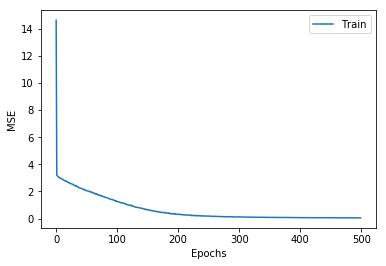

In [47]:
plt.figure()
plt.plot(history.history['mean_squared_error'])
plt.xlabel("Epochs")
plt.ylabel("MSE")
plt.legend(['Train'])
plt.show()